# Import thư viện

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [3]:
!pip install shap

In [4]:
import shap

# Load dữ liệu

In [6]:
dataset = pd.read_csv('data/car_price.csv')

In [7]:
dataset.shape

(205, 26)

In [8]:
dataset.head(3)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

16 giá trị numerical: 
- `car_ID`:  ID của xe 
- `symboling`: Đánh giá rủi ro của xe theo Acturian (giá trị số, trong đó -3 là an toàn, +3 là rủi ro)  
- `wheelbase`: Chiều dài cơ sở của xe (tính bằng inch)  
- `carlength`: Chiều dài xe (tính bằng inch)  
- `carwidth`: Chiều rộng xe (tính bằng inch)  
- `carheight`: Chiều cao xe (tính bằng inch)  
- `curbweight`: Trọng lượng không tải của xe (tính bằng pound)  
- `enginesize`: Dung tích động cơ (giá trị số tính bằng inch khối)   
- `boreratio`: Tỷ số Bore-Stroke của xe (tỷ lệ giữa đường kính xy-lanh động cơ và chiều dài hành trình piston)  
- `stroke`: Hành trình piston của xe (giá trị số)  
- `compressionratio`: Tỷ số nén của xe (tỷ lệ giữa thể tích xy-lanh khi piston ở vị trí thấp nhất Vbottom (thể tích lớn nhất) và vị trí cao nhất Vtop (thể tích nhỏ nhất))  
- `horsepower`: Công suất của xe (giá trị số, tính bằng mã lực)  
- `peakrpm`: Số vòng quay tối đa của xe (tính bằng vòng/phút)  
- `citympg`: Mức tiêu hao nhiên liệu trong thành phố (dặm/gallon)  
- `highwaympg`: Mức tiêu hao nhiên liệu trên đường cao tốc (dặm/gallon)  
- `price`: Tổng giá trị của xe (tính bằng đô la)

10 giá trị categorical: 
- `fueltype`: Loại nhiên liệu của xe (gas hoặc diesel), gas chiếm đa số 
- `aspiration`: Kiểu hút khí của xe (standard hoặc turbo), std chiếm đa số
- `doornumber`: Số cửa của xe (two hoặc four)  
- `carbody`: Kiểu thân xe (convertible, sedan, hatchback, wagon, hoặc hardtop)  
- `drivewheel`: Hệ dẫn động của xe (rear wheel drive, 4 wheel drive hoặc front wheel drive)  
- `enginelocation`: Vị trí động cơ của xe (front hoặc rear), hầu hết các giá trị đều là front   
- `enginetype`: Loại động cơ của xe (dohc, dohcv, I, ohc, ohcf, ohcv hoặc rotor)  
- `cylindernumber`: Số lượng xy-lanh của xe (two, three, four, five, six, eight, hoặc twelve)  
- `fuelsystem`: Hệ thống nhiên liệu của xe (1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi hoặc spfi)  



In [11]:
dataset.duplicated().sum()

0

- Data có 205 hàng, 26 cột, không có giá trị thiếu và hàng trùng lặp

# Chia tập train/test

In [14]:
X = dataset.drop('price', axis=1)
y = dataset['price']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,random_state=42)

In [15]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [16]:
df_train.shape

(164, 26)

In [17]:
df_test.shape

(41, 26)

# 1. Phân tích dữ liệu

## 1.1. Phân tích đơn biến

### 1.1.1 Numerical

In [21]:
numerical_features = ['symboling','wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                      'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                      'peakrpm', 'citympg', 'highwaympg', 'price']

car_ID không cần thiết nên sẽ xử lý để loại bỏ

In [23]:
df_train.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,101.865854,0.902439,98.728659,174.127439,65.922561,53.715854,2556.439024,126.414634,3.320854,3.254909,10.089085,104.701220,5144.207317,25.073171,30.573171,13223.414634
std,59.942664,1.244470,5.968884,12.080544,2.123469,2.479386,511.935461,40.469014,0.269766,0.317892,3.854172,40.228058,493.839328,6.164972,6.435199,7746.206406
min,1.000000,-2.000000,86.600000,144.600000,61.800000,47.800000,1819.000000,70.000000,2.540000,2.070000,7.000000,52.000000,4150.000000,13.000000,16.000000,5118.000000
25%,48.750000,0.000000,94.500000,166.675000,64.175000,51.900000,2163.000000,98.000000,3.150000,3.110000,8.600000,71.500000,4800.000000,19.000000,25.000000,7705.750000
50%,105.500000,1.000000,96.750000,173.100000,65.500000,54.100000,2422.500000,119.500000,3.310000,3.280000,9.000000,95.000000,5200.000000,24.000000,30.000000,10646.500000
75%,152.500000,2.000000,102.100000,183.200000,66.675000,55.525000,2939.250000,141.000000,3.540000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16525.750000
max,205.000000,3.000000,115.600000,202.600000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,45.000000,50.000000,45400.000000


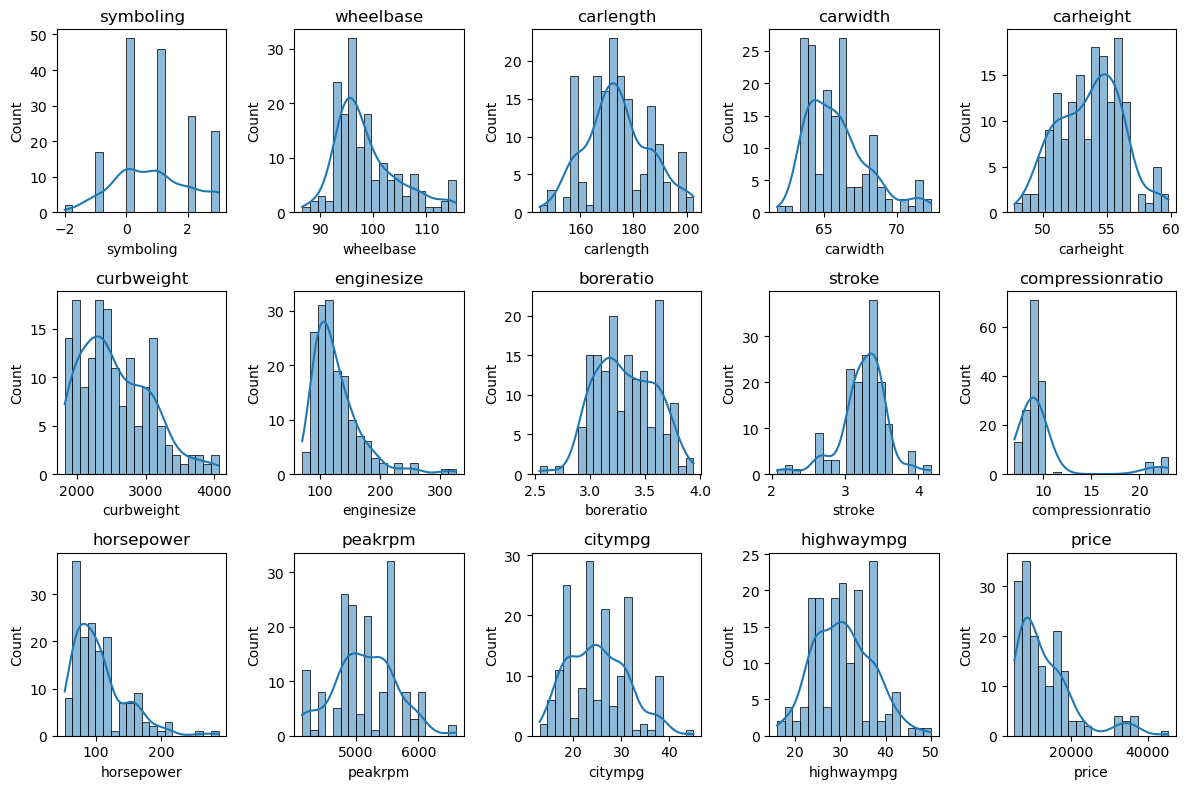

In [24]:
plt.figure(figsize=(12, 8))
for feature in numerical_features:
    plt.subplot(3, 5, numerical_features.index(feature) + 1)
    sns.histplot(data=df_train[feature], bins=20, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

- Một số biến có phân phối lệch phải (như `enginesize`, `horsepower`, `compressionratio`), có nghĩa là phần lớn dữ liệu tập trung ở các giá trị nhỏ hơn, trong khi một số ít có giá trị rất cao.
- Một số biến có phân phối gần chuẩn (như `boreratio`, `stroke`, `carheight`, `carlength`), cho thấy dữ liệu tập trung quanh một giá trị trung bình.
- Một số biến có phân bố dữ liệu không đều, với một số giá trị xuất hiện nhiều hơn hẳn so với các giá trị khác

### 1.1.2. Categorical

In [27]:
df_train.select_dtypes(include="object").nunique()

CarName           124
fueltype            2
aspiration          2
doornumber          2
carbody             5
drivewheel          3
enginelocation      2
enginetype          7
cylindernumber      6
fuelsystem          8
dtype: int64

In [28]:
categorical_features = ["fueltype", "aspiration", "doornumber", "carbody", "drivewheel", 
            "enginelocation", "enginetype", "cylindernumber", "fuelsystem", "CarName"]  

In [29]:
df_train.describe(include=['object'])

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,164,164,164,164,164,164,164,164,164,164
unique,124,2,2,2,5,3,2,7,6,8
top,peugeot 504,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,6,149,135,89,78,95,161,116,130,78


In [30]:
for col in categorical_features:
    print(f"Category in {col} is : {df_train[col].unique()}")  

Category in fueltype is : ['diesel' 'gas']
Category in aspiration is : ['std' 'turbo']
Category in doornumber is : ['four' 'two']
Category in carbody is : ['sedan' 'wagon' 'hatchback' 'hardtop' 'convertible']
Category in drivewheel is : ['rwd' 'fwd' '4wd']
Category in enginelocation is : ['front' 'rear']
Category in enginetype is : ['ohc' 'l' 'ohcf' 'dohc' 'rotor' 'ohcv' 'dohcv']
Category in cylindernumber is : ['four' 'six' 'five' 'two' 'twelve' 'eight']
Category in fuelsystem is : ['idi' 'mpfi' '2bbl' '1bbl' 'mfi' '4bbl' 'spdi' 'spfi']
Category in CarName is : ['mazda rx-7 gs' 'peugeot 504' 'toyota corona hardtop' 'nissan latio'
 'honda civic 1300' 'dodge monaco (sw)' 'subaru dl' 'peugeot 604sl'
 'dodge coronet custom (sw)' 'chevrolet monte carlo'
 'toyota corolla liftback' 'nissan gt-r' 'toyota corolla' 'nissan titan'
 'audi fox' 'toyota corona liftback' 'mazda glc' 'porsche boxter'
 'mitsubishi mirage' 'subaru r1' 'nissan teana' 'toyota mark ii'
 'mercury cougar' 'toyota celica gt'

Biến CarName sẽ cần phải xử lý riêng

In [32]:
categorical_features.remove('CarName')

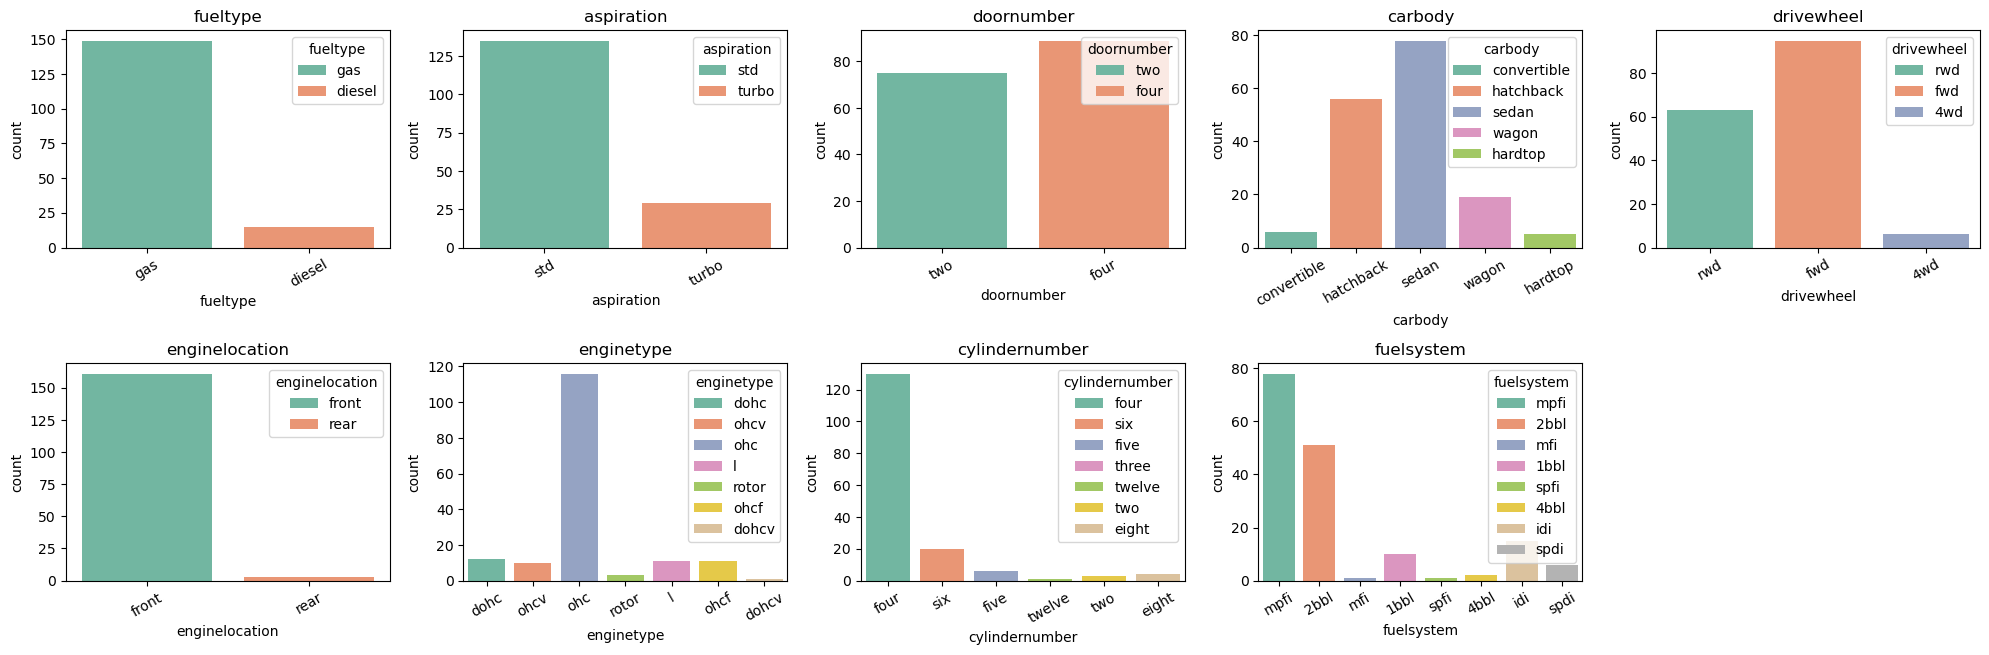

In [33]:
plt.figure(figsize=(20, 16))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(5, 5, i) 
    sns.countplot(x=df_train[feature], hue=dataset[feature], palette="Set2") 
    plt.title(feature)
    plt.xticks(rotation=30)  

plt.tight_layout()
plt.show()

- Số lượng cylinders sử dụng nhiều nhất là 4
- Số lượng xe sử dụng xăng nhiều hơn những chiếc xe sử dụng dầu diesel
- Sedan là loại xe hay được sử dụng nhất

## 1.2. Phân tích đa biến

### 1.2.1. Tương quan giữa các biến numerical

In [37]:
def plot_correlation_bar(df):
    correlation_with_price = df[numerical_features].corr()["price"].drop("price")

    plt.figure(figsize=(10, 5))
    sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values, palette="coolwarm")
    plt.ylabel("Correlation with Price")
    plt.xlabel("Features")
    plt.ylim(-1, 1)
    plt.axhline(0, color="black", linewidth=0.7, linestyle="--") 

    for i in range(len(correlation_with_price)):
        plt.text(i, correlation_with_price.iloc[i], round(correlation_with_price.iloc[i], 2), 
                 ha='center', va='bottom' if correlation_with_price.iloc[i] > 0 else 'top')

    plt.xticks(rotation=45)
    plt.show()

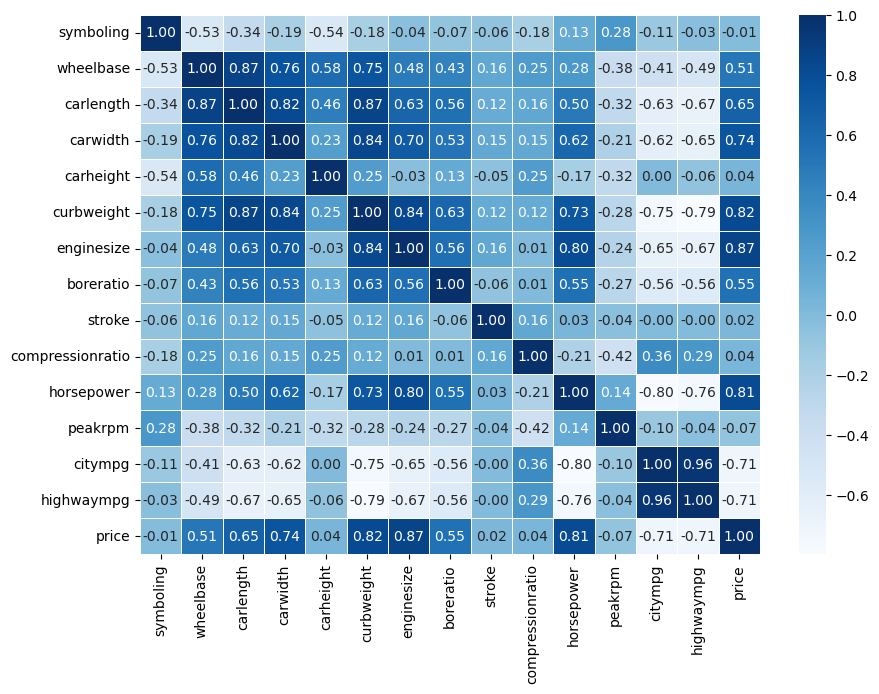

In [38]:
plt.figure(figsize=(10, 7))
correlation_matrix = df_train[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, fmt=".2f", cmap="Blues")
plt.show()

- highwaympg và citympg có tương quan cao, gần như đồng nhất 0.96:
  +  Cả hai đều có ảnh hưởng mạnh đến price và các đặc tính khác của xe như curbweight, horsepower, enginesize, carwidth.
  +   citympg có mối tương quan mạnh hơn với compressionratio và wheelbase, trong khi highwaympg có ảnh hưởng lớn hơn với các biến như curbweight và horsepower.
- symboling, stroke, compressionratio, peakrpm có tương quan thấp với tất cả các biến

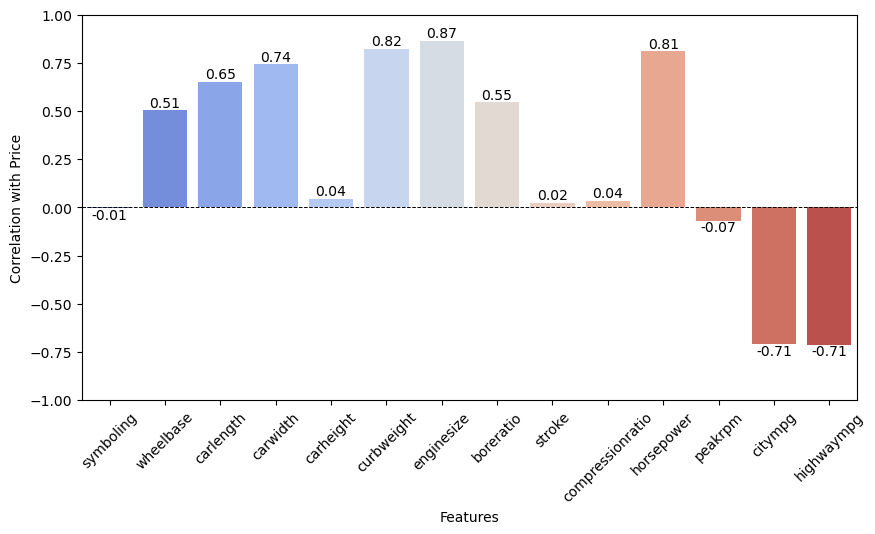

In [40]:
plot_correlation_bar(df_train)

- symboling, carheight, stroke, compressionratio, peakrpm có tương quan thấp với giá, gần như không liên quan đến giá.
- Mấy thuộc tính như symboling, stroke, compressionratio, carheight, peakrpm khi xét riêng lẻ thì ảnh hưởng gần như không đáng kể, nhưng điều đó không chứng minh là chúng hoàn toàn vô ích trong mô hình dự đoán price -> thử thêm SHAP values để hiểu mức độ đóng góp của từng feature trong mô hình

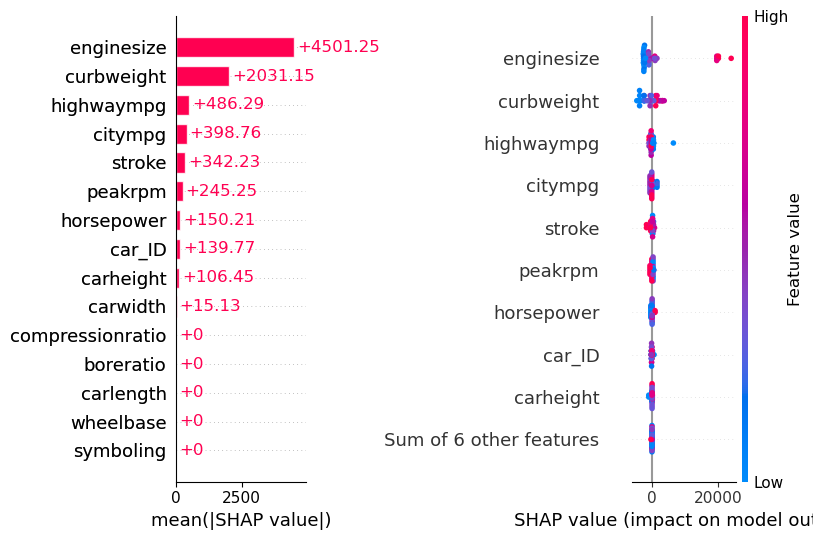

In [42]:
numerical_features1 = df_train.select_dtypes(include=['float64', 'int64']).columns
X_train_numeric = df_train[numerical_features1].drop(columns=['price'])
y_train = df_train['price'] 
X_test_numeric = df_test[numerical_features1].drop(columns=['price'])  
y_test = df_test['price'] 

model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train_numeric, y_train)

explainer = shap.Explainer(model, X_train_numeric)
shap_values = explainer(X_test_numeric)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))  
plt.sca(axes[0])
shap.plots.bar(shap_values, max_display=20, show=False)
plt.sca(axes[1])
shap.plots.beeswarm(shap_values, show=False)
plt.tight_layout()

= > Bỏ compressionratio, boreratio, carlength, wheelbase, symboling, citympg

### 1.3.2. Box plot giữa biến Categorical và Price

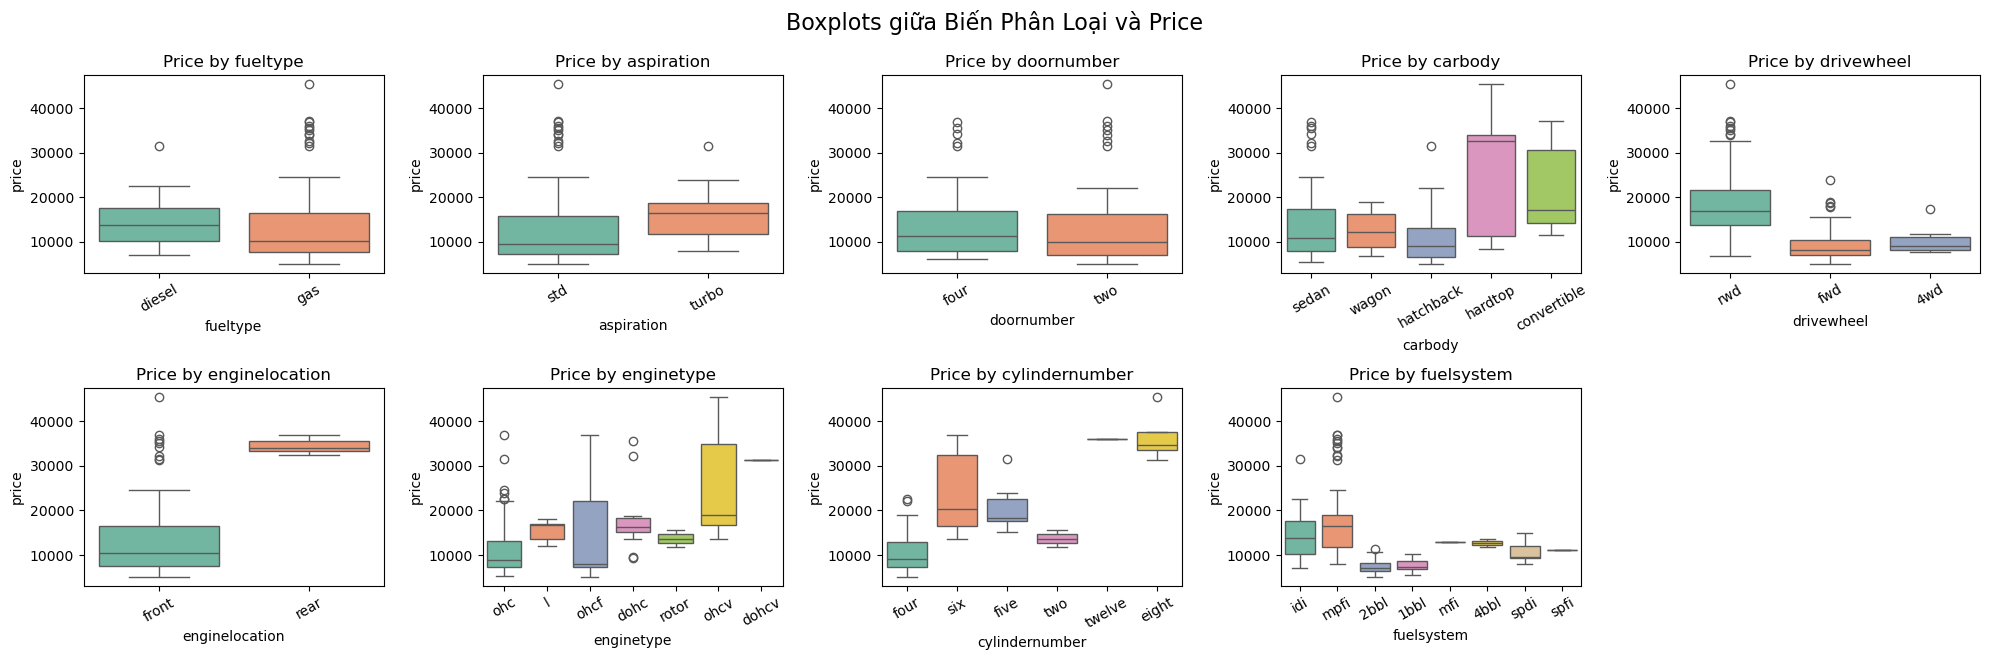

In [45]:
plt.figure(figsize=(20, 15))
for i, cat_col in enumerate(categorical_features, 1):
    plt.subplot(5, 5, i)
    
    sns.boxplot(data=df_train, x=cat_col, y="price", palette="Set2")
    plt.title(f"Price by {cat_col}", fontsize=12)
    plt.xticks(rotation=30)
    
    plt.xlabel(f"{cat_col}", fontsize=10)

plt.tight_layout()
plt.suptitle("Boxplots giữa Biến Phân Loại và Price", fontsize=16, y=1.02)
plt.show()


- Những chiếc xe có loại nhiên liệu là diesel có giá cao hơn so với những chiếc xe sử dụng nhiên liệu xăng.

- Tất cả các loại carbody đều có giá rẻ hơn so với carbody dạng convertible.

- Những chiếc xe có động cơ đặt ở phía sau (rear) có giá cao hơn rất nhiều so với những chiếc xe có động cơ phía trước (front).

- Giá xe có xu hướng tăng theo số lượng xi-lanh trong hầu hết các trường hợp.

- Loại động cơ "ohcv" có mặt trong các chiếc xe cao cấp hơn với mức giá cao.

- Doornumber không ảnh hưởng nhiều đến giá.

- Các xe giá cao có vẻ như thường sử dụng rwd.



# 2. Tiền xử lý và củng cố dữ liệu

## 2.1. Xử lý cột car_ID

Cột đầu tiên là ID xe. ID của xe chỉ là một con số để xác định xe này trong tập dữ liệu này. Vì vậy, cột này không thực sự là một phần thông tin mà chúng ta nên quan tâm. Chúng ta có thể bỏ cột này hoặc biến nó thành chỉ mục cho tập dữ liệu này.

In [50]:
df_train.set_index(df_train.car_ID, inplace=True)
df_train.drop("car_ID", axis=1, inplace=True)

df_test.set_index(df_test.car_ID, inplace=True)
df_test.drop("car_ID", axis=1, inplace=True)

## 2.2. Xử lý cột CarName

Đây là một đặc trưng phân loại với số lượng giá trị phân biệt khá lớn (124 giá trị) nên cần xử lý, có thể trích xuất thương hiệu xe để giảm sự phức tạp khi xử lý tên của từng mẫu xe cụ thể

In [53]:
df_train["Brand"] = df_train["CarName"].str.split().str[0] 

In [54]:
df_train.drop(columns=['CarName'], inplace=True)

In [55]:
df_train["Brand"].unique()

array(['mazda', 'peugeot', 'toyota', 'nissan', 'honda', 'dodge', 'subaru',
       'chevrolet', 'audi', 'porsche', 'mitsubishi', 'mercury', 'bmw',
       'saab', 'maxda', 'plymouth', 'volvo', 'alfa-romero', 'isuzu',
       'volkswagen', 'porcshce', 'buick', 'vw', 'jaguar', 'toyouta',
       'Nissan', 'renault'], dtype=object)

In [56]:
corrections = {
    "maxda": "mazda",
    "porcshce": "porsche",
    "vw": "volkswagen",
    "toyouta": "toyota",
    "Nissan": "nissan", 
}
df_train["Brand"] = df_train["Brand"].replace(corrections)
df_train["Brand"].unique() 

array(['mazda', 'peugeot', 'toyota', 'nissan', 'honda', 'dodge', 'subaru',
       'chevrolet', 'audi', 'porsche', 'mitsubishi', 'mercury', 'bmw',
       'saab', 'plymouth', 'volvo', 'alfa-romero', 'isuzu', 'volkswagen',
       'buick', 'jaguar', 'renault'], dtype=object)

Từ 27 brand giảm xuống còn 22

In [58]:
df_test["Brand"] = df_test["CarName"].str.split().str[0]
df_test.drop(columns=['CarName'], inplace=True)
df_test["Brand"] = df_test["Brand"].replace(corrections)

## 2.3. Chia Brand thành CarType

Với 22 brand để encoding thì sẽ khá nhiều cột, mô hình dữ liệu ít sẽ trở lên phức tạp

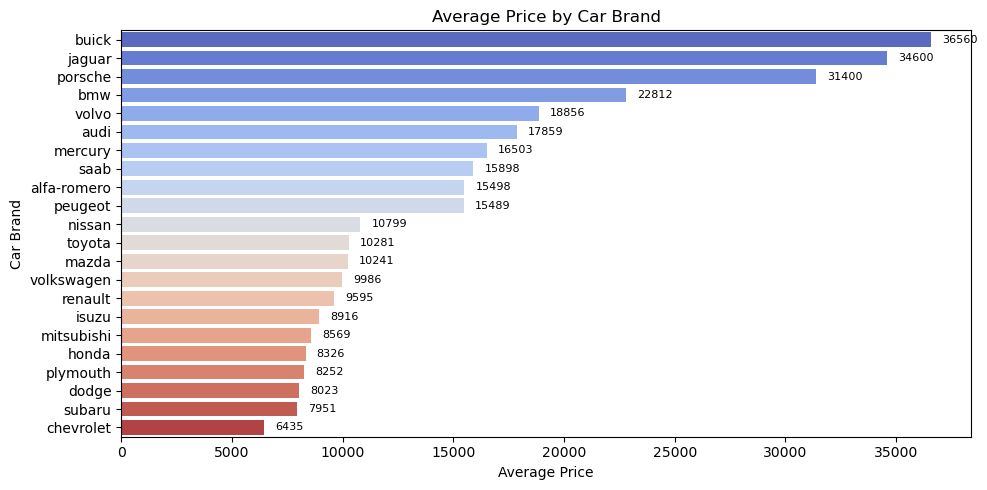

In [61]:
car_price_data = df_train[['Brand', 'price']]
avg_price_by_brand = car_price_data.groupby('Brand')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=avg_price_by_brand.values, y=avg_price_by_brand.index, palette="coolwarm")

for index, value in enumerate(avg_price_by_brand.values):
    ax.text(value + 500, index, f'{int(value)}', va='center', fontsize=8)  

plt.title("Average Price by Car Brand")
plt.xlabel("Average Price")
plt.ylabel("Car Brand")
plt.tight_layout()

In [62]:
brand_avg_price = df_train.groupby('Brand')['price'].mean().reset_index()
brand_avg_price.columns = ['Brand', 'AvgPrice']
def assign_car_type(price):
    if price < 10000:
        return 'Economy'
    elif price < 20000:
        return 'Mid-range'
    else:
        return 'Luxury'

brand_avg_price['CarType'] = brand_avg_price['AvgPrice'].apply(assign_car_type)

df_train = df_train.merge(brand_avg_price[['Brand', 'CarType']], on='Brand', how='left')
df_train.drop(columns=['Brand'], inplace=True)

In [63]:
df_test = df_test.merge(brand_avg_price[['Brand', 'CarType']], on='Brand', how='left')
df_test.drop(columns=['Brand'], inplace=True)

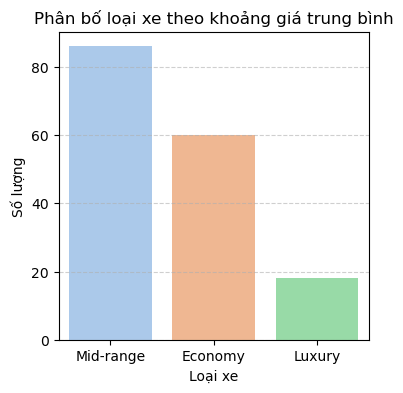

In [64]:
plt.figure(figsize=(4,4))
sns.countplot(x='CarType', data=df_train, palette='pastel')
plt.title('Phân bố loại xe theo khoảng giá trung bình')
plt.xlabel('Loại xe')
plt.ylabel('Số lượng')
plt.grid(axis='y', linestyle='--', alpha=0.6)

## 2.3. Xử lý ngoại lai

In [66]:
def plot_boxplots(dataset, features): 
    plt.figure(figsize=(10, 5))
    for idx, feature in enumerate(features):
        plt.subplot(2, 5, idx + 1)
        sns.boxplot(data=df_train, y=feature, palette='Set2')
        plt.title(feature)
    plt.tight_layout()
    plt.show()

Columns with outliers: ['wheelbase', 'carwidth', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'highwaympg', 'price']


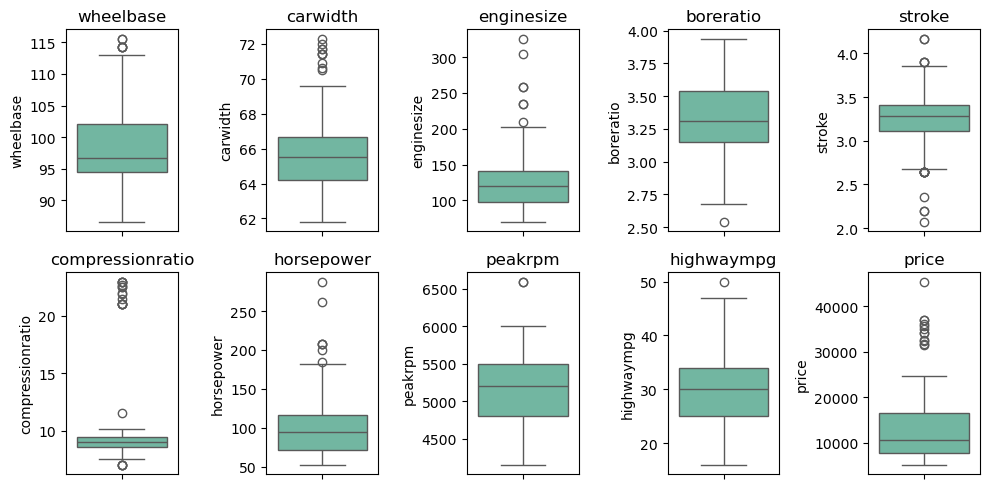

In [67]:
outlier_cols = []
for column in numerical_features:
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df_train[column] < lower_bound) | (df_train[column] > upper_bound)
    if outliers.any():
        outlier_cols.append(column)

print("Columns with outliers:", outlier_cols)
plot_boxplots(df_train, outlier_cols)

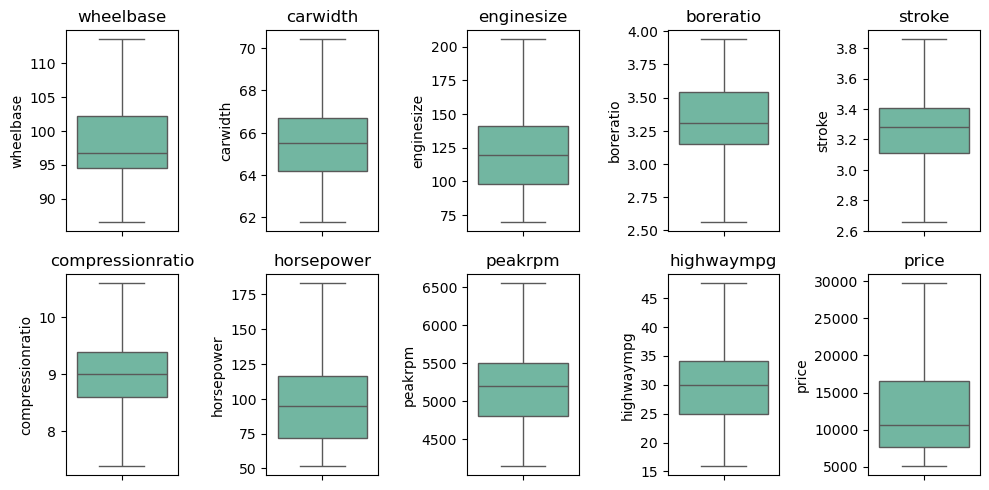

In [68]:
for column in outlier_cols:
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_train[column] = df_train[column].clip(lower=lower_bound, upper=upper_bound)
    df_test[column] = df_test[column].clip(lower=lower_bound, upper=upper_bound)
    
plot_boxplots(df_train, outlier_cols)

## 2.4. Mã hóa dữ liệu categorical

In [70]:
categorical_features = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation',
 'enginetype','cylindernumber','fuelsystem','CarType']

In [71]:
for col in categorical_features:
    print(f"Category in {col} : {df_train[col].unique()}")  

Category in fueltype : ['diesel' 'gas']
Category in aspiration : ['std' 'turbo']
Category in doornumber : ['four' 'two']
Category in carbody : ['sedan' 'wagon' 'hatchback' 'hardtop' 'convertible']
Category in drivewheel : ['rwd' 'fwd' '4wd']
Category in enginelocation : ['front' 'rear']
Category in enginetype : ['ohc' 'l' 'ohcf' 'dohc' 'rotor' 'ohcv' 'dohcv']
Category in cylindernumber : ['four' 'six' 'five' 'two' 'twelve' 'eight']
Category in fuelsystem : ['idi' 'mpfi' '2bbl' '1bbl' 'mfi' '4bbl' 'spdi' 'spfi']
Category in CarType : ['Mid-range' 'Economy' 'Luxury']


In [72]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    # Áp dụng transform cho df_test và xử lý các giá trị chưa thấy
    df_test[feature] = df_test[feature].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

In [73]:
df_train.head(3)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarType
0,0,0,0,0,3,2,0,104.9,175.0,66.1,...,3,3.43,3.64,10.6,72.0,4200,31,39.0,18344.0,2
1,0,1,0,0,3,2,0,107.9,186.7,68.4,...,5,3.46,2.66,8.4,95.0,5000,19,24.0,15580.0,2
2,0,1,0,0,4,1,0,95.7,169.7,63.6,...,1,3.05,3.03,9.0,62.0,4800,31,37.0,6918.0,2


# 3. Xây dựng mô hình

In [75]:
X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)
y_train = df_train['price']
y_test = df_test['price']

columns_to_drop = [ "compressionratio" , "boreratio" , "carlength", "wheelbase" , "symboling", "citympg"]
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# 4. Đánh giá kết quả

In [79]:
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2
    
metrics_lr = evaluate_model(y_test, y_pred_lr)
metrics_dt = evaluate_model(y_test, y_pred_dt)
metrics_rf = evaluate_model(y_test, y_pred_rf)

In [80]:
print("Linear Regression - MAE: {}, RMSE: {}, R2: {}".format(*metrics_lr))
print("Decision Tree - MAE: {}, RMSE: {}, R2: {}".format(*metrics_dt))
print("Random Forest - MAE: {}, RMSE: {}, R2: {}".format(*metrics_rf))

Linear Regression - MAE: 2123.850760473499, RMSE: 2750.381064966466, R2: 0.8583513204882074
Decision Tree - MAE: 1156.2906585365854, RMSE: 1671.637032018125, R2: 0.9476748166863159
Random Forest - MAE: 1034.291048780488, RMSE: 1407.65651501855, R2: 0.9628960470344395


Trước khi xử lý ngoại lai thì:
- Linear Regression - MAE: 2594.9002523453078, RMSE: 3813.864093897, R2: 0.8157484358581462
- Decision Tree - MAE: 2011.235780487805, RMSE: 2886.532331159, R2: 0.8944559853173938
- Random Forest - MAE: 1270.212573170732, RMSE: 1837.347458847, R2: 0.9572374747711523

-> có cải thiện trên cả 3 mô hình


- Random Forest cho kết quả tốt nhất về mọi mặt (MAE, MSE, RMSE thấp nhất và R² cao nhất), chứng tỏ mô hình học tốt nhất mối quan hệ giữa feature và giá.

- Decision Tree khá ổn, cải thiện hơn nhiều so với Linear Regression.

- Linear Regression tuy đơn giản nhưng hiệu quả kém hơn rõ rệt do không bắt được phi tuyến tính giữa các biến.

# 5. Phân tích lỗi, nhận xét

In [84]:
def plot_residuals_row(y_test, preds, model_names):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
    
    for i, ax in enumerate(axes):
        residuals = y_test - preds[i]
        ax.scatter(preds[i], residuals, alpha=0.5)
        ax.axhline(0, color='red', linestyle='--')
        ax.set_title(f'Residual - {model_names[i]}')
        ax.set_xlabel('Predicted Price')
        if i == 0:
            ax.set_ylabel('Residuals')
        ax.grid(True)

    plt.tight_layout()

def plot_actual_vs_pred_row(y_test, preds, model_names):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

    for i, ax in enumerate(axes):
        ax.scatter(y_test, preds[i], alpha=0.5)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
        ax.set_title(f'{model_names[i]}')
        ax.set_xlabel('Actual Price')
        if i == 0:
            ax.set_ylabel('Predicted Price')
        ax.grid(True)

    plt.tight_layout()

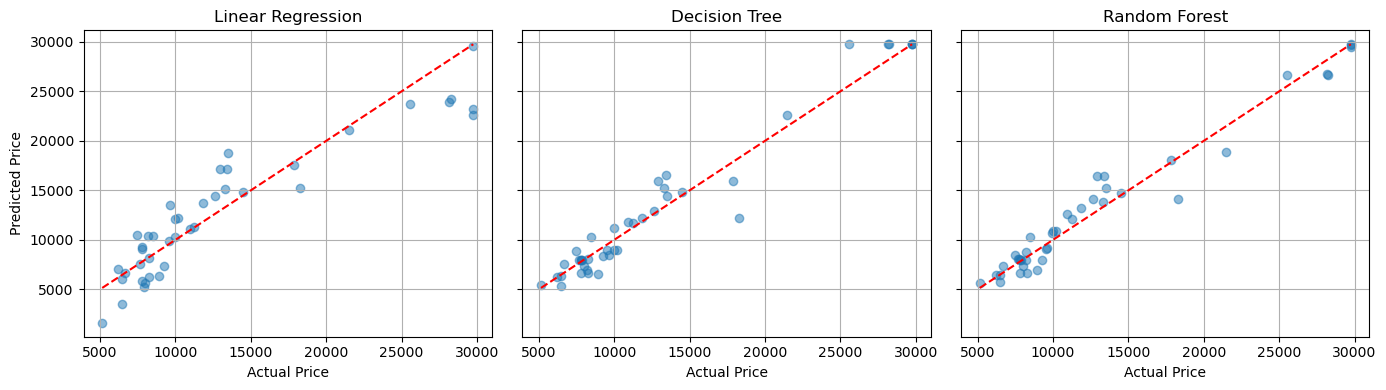

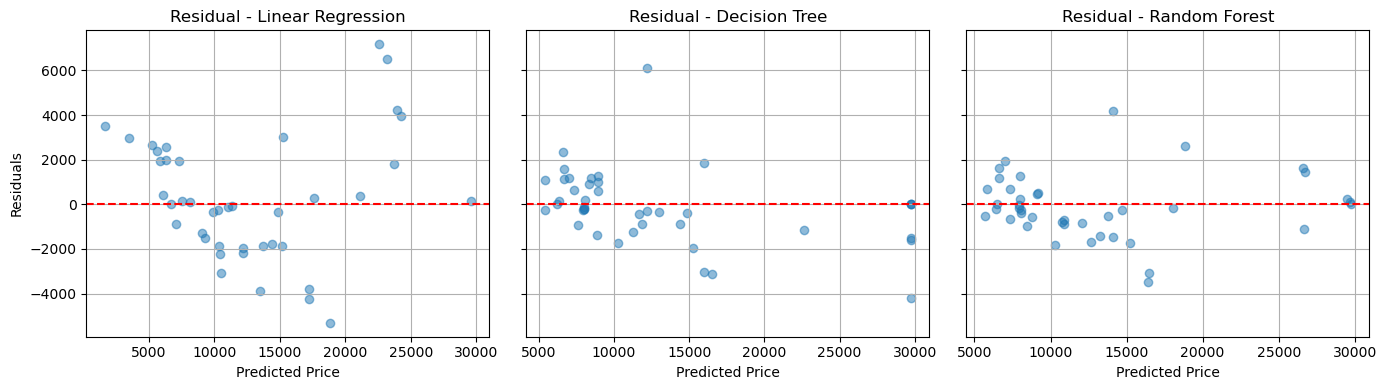

In [85]:
plot_actual_vs_pred_row(
    y_test, 
    [y_pred_lr, y_pred_dt, y_pred_rf], 
    ["Linear Regression", "Decision Tree", "Random Forest"]
)
plot_residuals_row(
    y_test, 
    [y_pred_lr, y_pred_dt, y_pred_rf], 
    ["Linear Regression", "Decision Tree", "Random Forest"]
)

1. Linear Regression:

- Biểu đồ dự đoán: Mối quan hệ giữa giá trị thực tế và giá trị dự đoán có vẻ là tuyến tính, nhưng không hoàn hảo (đặc biệt ở các giá trị thực tế cao hơn, giá trị dự đoán có xu hướng vượt xa).
-> mô hình chưa hoàn toàn chính xác trong việc dự đoán giá trị cực đại

- Residuals: Dù các điểm phân tán khá đều quanh giá trị 0, vẫn thấy một số điểm dư lớn và có xu hướng gia tăng ở các giá trị dự đoán cao hơn. Điều này chỉ ra rằng mô hình có thể chưa hoàn toàn phù hợp cho các giá trị cực trị (outliers). Phân bố phần dư không hoàn toàn ngẫu nhiên và có thể có một số khuynh hướng hoặc mối quan hệ chưa được mô hình bắt đúng

2. Decision Tree :

- Biểu đồ dự đoán: Mô hình có thể dự đoán tốt với các giá trị trong khoảng giá thấp, nhưng đối với các giá trị cao hơn, sự phân tán trở nên lớn hơn, có thể do mô hình cây quyết định không đủ linh hoạt để nắm bắt các đặc điểm phức tạp ở mức giá cao.

- Residuals: Residuals không phân bố đều mà tập trung quanh các giá trị nhỏ hơn, điều này cho thấy mô hình có thể không tốt khi dự đoán các giá trị cực đoan hoặc không phản ánh đúng sự biến thiên của giá trị thực tế. 

3. Random Forest:

- Biểu đồ dự đoán: Tương tự Decision Tree, nhưng có vẻ mô hình Random Forest ít bị overfitting hơn, thể hiện sự phân bố điểm dữ liệu mượt mà hơn, gần với đường chéo.

- Residuals: Residuals phân bố khá đều xung quanh đường ngang, nhưng một số điểm vẫn có residuals lớn, chỉ ra rằng mô hình có thể chưa hoàn toàn tối ưu, mặc dù không bị overfitting như cây quyết định.